In [1]:
import sys
sys.path.append("../")
sys.path.append("../..")
sys.path.append("../../../")
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
data = load_iris()
iris = load_iris()

from clust.tool.plot import plot_features
from clust.transformation.featureReduction import featureExtraction

In [2]:
def checkResult(result):
    # 1. Plot 3D Graph with color - predic
    plot_features.show3Dgraph(data, result['predict']) # data, color
    # 2. prediction result plot
    result['predict'].plot()
    # crosstab table by labels and prediction result
    ct = pd.crosstab(result['labels'], result['predict'])
    return ct
data = pd.DataFrame(iris.data, columns =['Sepal length','Sepal width','Petal length','Petal width']) # 4 columns
result = pd.DataFrame(iris.target, columns=['labels'])

int64


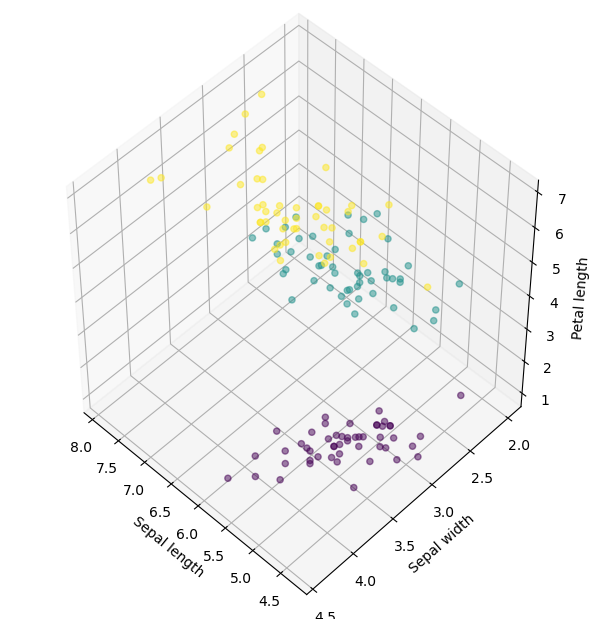

In [3]:
plot_features.show3Dgraph(data, colorData = result['labels'])

# 평범한 클러스터링

int64


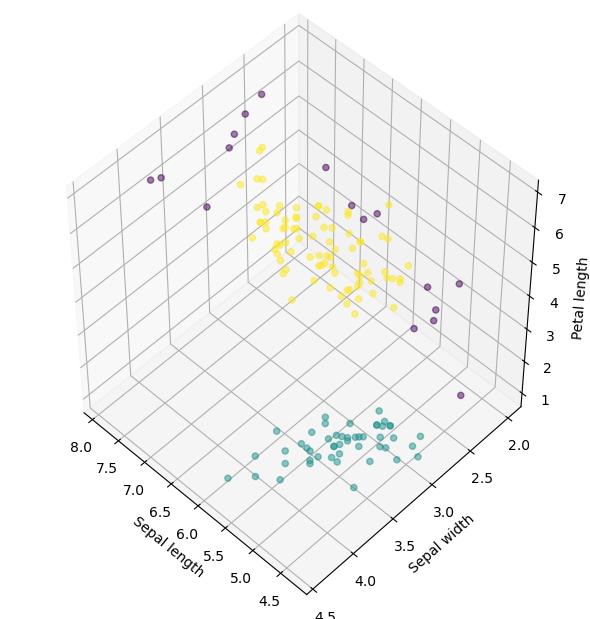

predict,-1,0,1
labels,,,
0,1,49,0
1,6,0,44
2,10,0,40


In [4]:
from clust.ML.clustering.interface import ClusteringByMinPoints
clusteringMethod ="DBSCAN"
minPts = 5

inputData = data
result['predict'] = ClusteringByMinPoints(inputData, minPts, "DBSCAN")
checkResult(result)

### Feature Reduction (PCA, TSNE)

In [5]:
# TSNE
inputData = data
n_components = 3
reductionMethod = "TSNE" #['PCA', 'TSNE']


int64


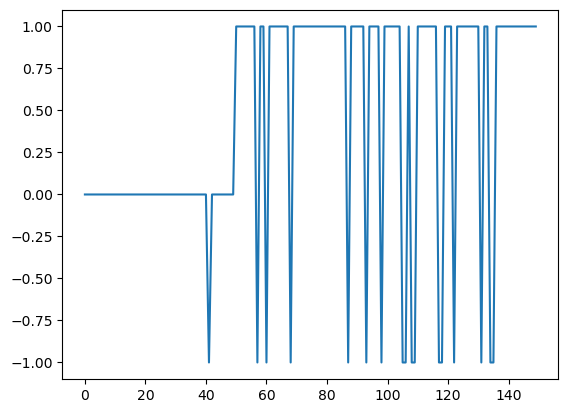

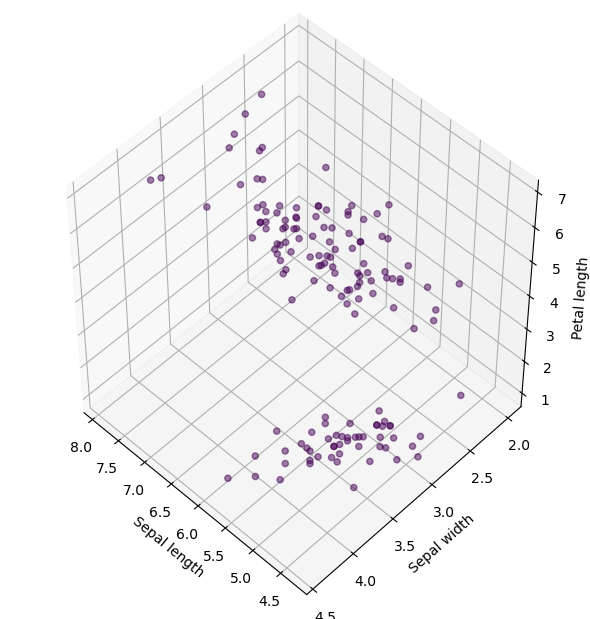

predict,-1
labels,
0,50
1,50
2,50


In [6]:
from clust.transformation.general import basicTransform
inputData = basicTransform.getRobustScaledDF(inputData)
FE_data = featureExtraction.featureReduction(inputData, n_components, reductionMethod)

inputData = FE_data
result['predict'] = ClusteringByMinPoints(inputData, minPts, clusteringMethod)
checkResult(result)

## Isolation Forest
https://partrita.github.io/posts/isolation-forest/

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.ensemble import IsolationForest

In [8]:
rng = np.random.RandomState(42)
# Generating training data 
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])
# Generating new, 'normal' observation
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])
# Generating outliers
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

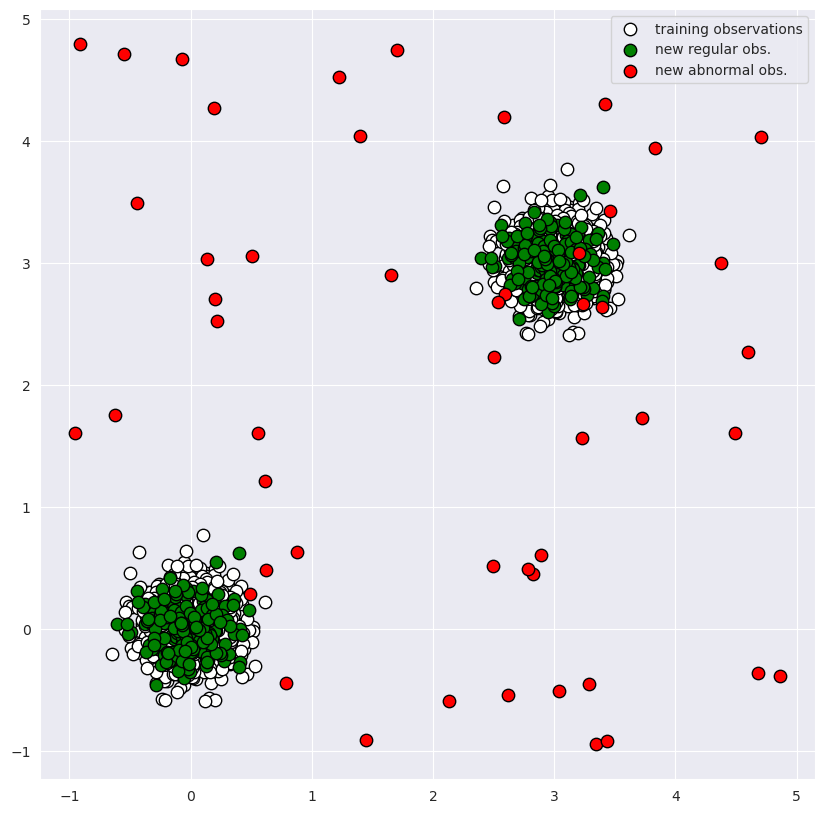

In [9]:
plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(X_train.x1, X_train.x2, c='white', s=20*4, edgecolor='k', label='training observations')
p2 = plt.scatter(X_test.x1, X_test.x2, c='green', s=20*4, edgecolor='k', label='new regular obs.')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*4, edgecolor='k', label='new abnormal obs.')

plt.legend()

In [10]:
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=42)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

/home/jwmoon/.conda/envs/sejong/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



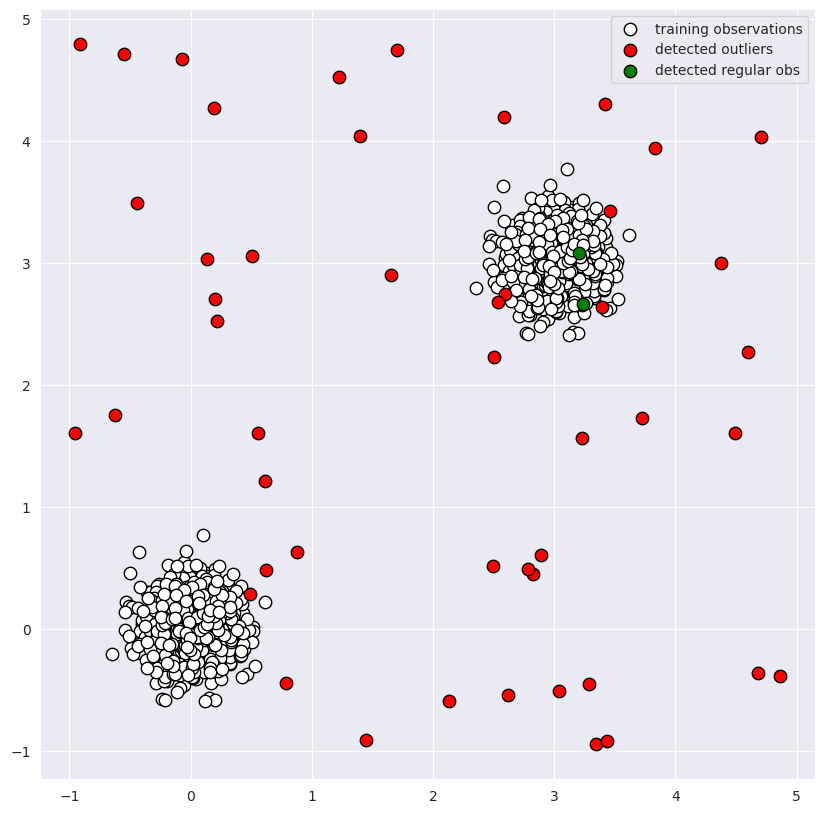

In [11]:
X_outliers = X_outliers.assign(y = y_pred_outliers)
p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="detected regular obs")
plt.legend()

In [12]:
print("테스트 데이터셋에서 정확도:", list(y_pred_test).count(1)/y_pred_test.shape[0])
print("이상치 데이터셋에서 정확도:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

테스트 데이터셋에서 정확도: 0.925
이상치 데이터셋에서 정확도: 0.96


## K Means Clustering

In [13]:
# -*- coding: utf-8 -*-
"""
k-means
=======

This example uses :math:`k`-means clustering for time series. Three variants of
the algorithm are available: standard
Euclidean :math:`k`-means, DBA-:math:`k`-means (for DTW Barycenter
Averaging [1])
and Soft-DTW :math:`k`-means [2].

In the figure below, each row corresponds to the result of a different
clustering. In a row, each sub-figure corresponds to a cluster.
It represents the set
of time series from the training set that were assigned to the considered
cluster (in black) as well as the barycenter of the cluster (in red).

A note on pre-processing
~~~~~~~~~~~~~~~~~~~~~~~~

In this example, time series are preprocessed using
`TimeSeriesScalerMeanVariance`. This scaler is such that each output time
series has zero mean and unit variance.
The assumption here is that the range of a given time series is uninformative
and one only wants to compare shapes in an amplitude-invariant manner (when
time series are multivariate, this also rescales all modalities such that there
will not be a single modality responsible for a large part of the variance).
This means that one cannot scale barycenters back to data range because each
time series is scaled independently and there is hence no such thing as an
overall data range.

[1] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method \
for dynamic time warping, with applications to clustering. Pattern \
Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693
[2] M. Cuturi, M. Blondel "Soft-DTW: a Differentiable Loss Function for \
Time-Series," ICML 2017.
"""

# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = X_train[y_train < 4]  # Keep first 3 classes
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# Make time series shorter
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

In [14]:
def showClusteringResult(km, y_pred, cluster_num):
    plt.figure(figsize=(12,4))
    for yi in range(cluster_num):
        plt.subplot(1, cluster_num, yi + 1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
        if yi == 1:
            pass
    plt.tight_layout()
    plt.show()

Euclidean KMeans
16.434 --> 9.437 --> 9.437 --> 


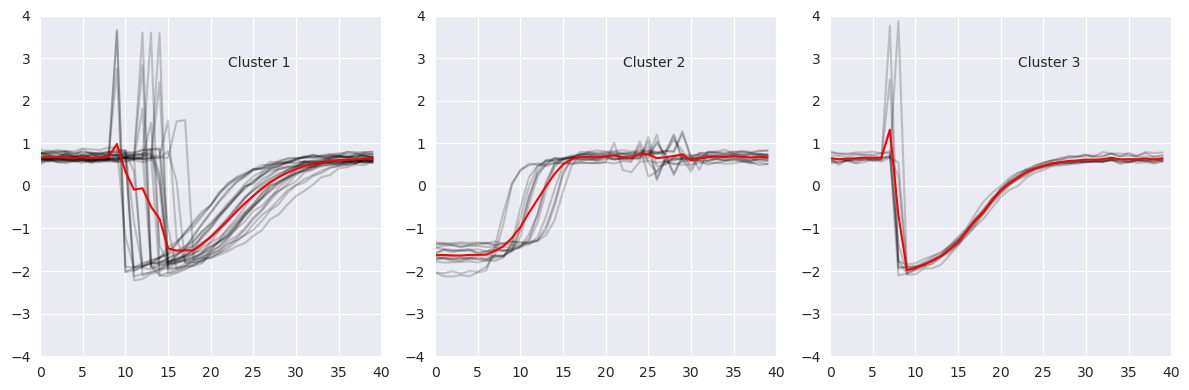

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


0.637 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


0.458 --> 0.458 --> 
Init 2
0.826 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


0.525 --> 0.477 --> 0.472 --> 0.472 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


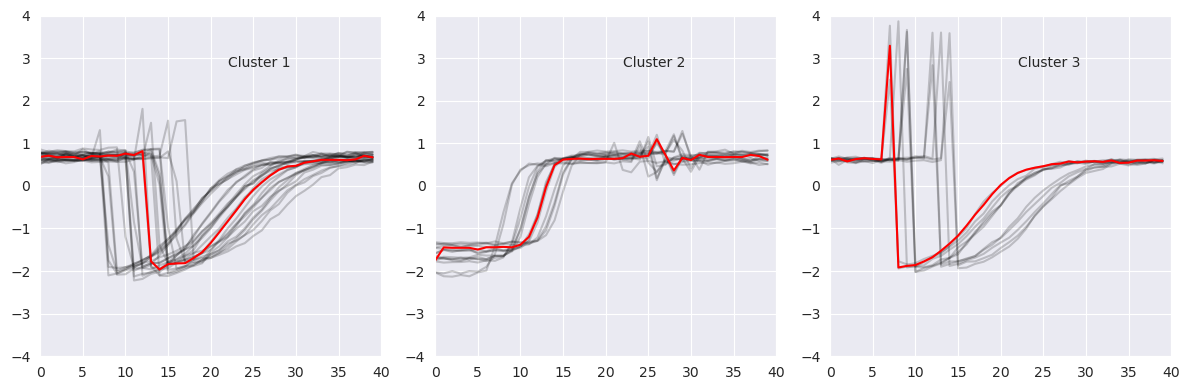

Soft-DTW k-means
0.472 --> 0.144 --> 0.142 --> 0.143 --> 0.142 --> 0.143 --> 0.142 --> 0.143 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 0.142 --> 


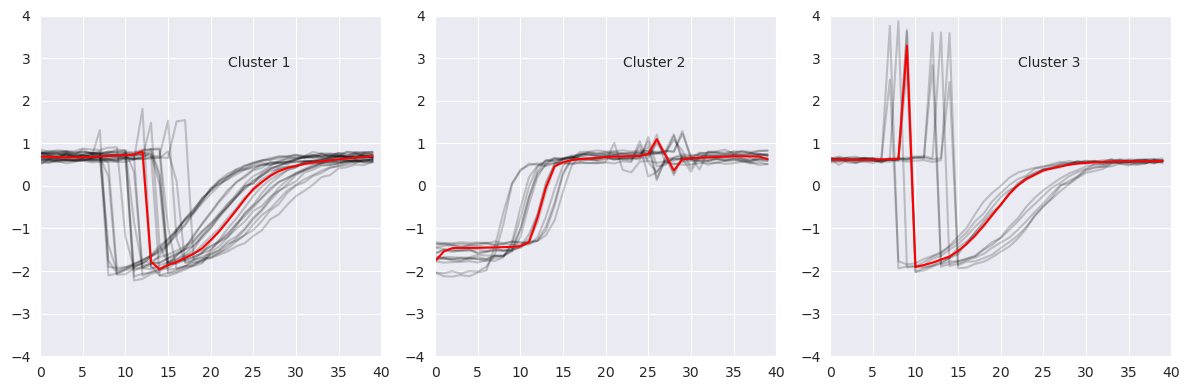

In [15]:
cluster_num = 3

# 1. Euclidean k-means
print("Euclidean KMeans")
km = TimeSeriesKMeans(n_clusters=cluster_num, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
showClusteringResult(km, y_pred, cluster_num)

# 2. DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=cluster_num, n_init=2, metric="dtw", verbose=True, max_iter_barycenter=10, random_state=seed)
y_pred = dba_km.fit_predict(X_train)
showClusteringResult(dba_km, y_pred, cluster_num)

# 3. Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)
showClusteringResult(sdtw_km, y_pred, cluster_num)